In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
# IMP: Do remove it before sending it to anyone
API_KEY = ""
SOURCE_VIDEO = '/content/drive/MyDrive/Genuin Assignment/single_class_ip/JqNjeNeJzuA.mp4'
FRAMES_FOLDER_ADDRESS = "/content/JqNjeNeJzuA"

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Jan  3 06:48:36 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace
!pip install anthropic

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 29.07 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
/usr/local/lib/python3.1

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

import cv2
import base64
from anthropic import Anthropic
import json
import re
import matplotlib.pyplot as plt
import json

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_tiny.pt"
CONFIG = "sam2_hiera_t.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [ ]:
# SOURCE_VIDEO = download_assets(VideoAssets.BASKETBALL)
# SOURCE_VIDEO = '/content/drive/MyDrive/tmp_proj/double_class_ip/S3r4CFtv9uU.mp4'

obj = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
width, height, fps, total_frames = obj.width, obj.height, obj.fps, obj.total_frames
print(width, height, fps, total_frames)

1920 1080 25 1987


**NOTE:** To reduce VRAM requirements, we are introducing three additional parameters: `SCALE_FACTOR` to decrease the frame resolution, and `START_IDX` and `END_IDX` to extract only the relevant segments from the video.

In [ ]:
# Do change the START_IDX, END_IDX and also the frame id which is used for the annotation

SCALE_FACTOR = 0.5 # Have to experiment with it by removing it
START_IDX = 100 # Also, have to manage both of them
END_IDX = 300

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 200/200 [00:07<00:00, 27.88it/s]


**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [ ]:
sam2_model.reset_state(inference_state)

### Prompting with points

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** SAM2 allows tracking multiple objects at once. Update the `OBJECTS` list if you want to change the list of tracked objects.

In [ ]:
num_images = 5

def analyze_video_frames_unique(video_path, api_key):
    client = Anthropic(api_key=api_key)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_images

    frames_base64 = []
    for i in range(num_images):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            _, buffer = cv2.imencode('.jpg', frame)
            frames_base64.append(base64.b64encode(buffer).decode('utf-8'))

    cap.release()

    messages = [{
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": """Return ONLY a JSON array with exactly 2 items containing unique main objects from these frames, prioritizing humans or living beings if present. Rules:
            1. Format: ["Object1", "Object2"] or ["Object1", null]
            2. Maximum 2 unique objects
            3. Focus on humans or living beings first before considering non-living objects.
            4. No explanation text, just the JSON array"""
        }
        ]
    }]

    for img_base64 in frames_base64:
        messages[0]["content"].append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": img_base64
            }
        })

    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=150,
        messages=messages
    )

    # Extract JSON array using regex
    json_match = re.search(r'\[.*?\]', response.content[0].text)
    if json_match:
        return json.loads(json_match.group())
    return [None, None]

In [ ]:
api_key = API_KEY
video_path = SOURCE_VIDEO
unique_objects = analyze_video_frames_unique(video_path, api_key)
print(unique_objects)

['Spiderman', 'Empire State Building']


In [ ]:
OBJECTS = unique_objects

In [ ]:
# # Fix the claude API, giving not probable things (doing tmp fixing)
# OBJECTS = ['Spider-Man.']

In [ ]:
def make_pixel_grid_with_lines(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add grid lines and pixel labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (255, 255, 255)  # White color in RGB
    thickness = 2

    step = 100  # Distance between lines

    for x in range(0, image.shape[1], step):  # Vertical lines
        cv2.line(image, (x, 0), (x, image.shape[0] - 1), color, thickness)
        # cv2.putText(image, f'{x}', (x + 5, 15), font, font_scale, color, thickness)

    for y in range(0, image.shape[0], step):  # Horizontal lines
        cv2.line(image, (0, y), (image.shape[1] - 1, y), color, thickness)
        # cv2.putText(image, f'{y}', (5, y + 15), font, font_scale, color, thickness)

    # Display the image with matplotlib and save with tight layout
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('on')  # Show axes with pixel values
    plt.grid(False)  # Disable Matplotlib's default grid

    # Save the image without extra white space
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
def extract_coordinates(response, num_objects):
    try:
        # Extract all coordinates from the response using regex
        coordinates = re.findall(r"\((\d+),\s*(\d+)\)", response)
        coordinates = [(int(x), int(y)) for x, y in coordinates]

        # If the number of extracted coordinates matches the expected number, return them
        if len(coordinates) == num_objects:
            return coordinates

        # If more coordinates are provided, group and select the central one for each object
        elif len(coordinates) > num_objects:
            # Calculate the central coordinate
            center_x = np.mean([x for x, y in coordinates])
            center_y = np.mean([y for x, y in coordinates])

            # Sort by distance to the central point
            coordinates_sorted = sorted(
                coordinates,
                key=lambda coord: np.sqrt((coord[0] - center_x) ** 2 + (coord[1] - center_y) ** 2)
            )

            # Return the first 'num_objects' coordinates
            return coordinates_sorted[:num_objects]

        else:
            raise ValueError("Not enough coordinates extracted for the specified number of objects.")

    except Exception as e:
        print(f"Error: Could not parse coordinates from response\n{e}")
        return []

In [ ]:
def analyze_image_coordinates(api_key, image_path, objects_to_find):
    client = Anthropic(api_key=api_key)

    mime_type = 'image/jpeg'  # Default to PNG if can't detect

    # Read and encode image
    with open(image_path, "rb") as f:
        image_bytes = f.read()
        image_base64 = base64.b64encode(image_bytes).decode('utf-8')

    prompt = f"I have an image containing specific objects. The image is divided into a grid with labeled coordinates for both x and y axes. Please identify the an point (x, y) coordinates of the specified objects in the image, make sure that the point lies in that object not at extreme end of object. For this image, the objects to locate are [{', '.join(objects_to_find)}]. Provide the coordinates for each object based on the grid."

    try:
        message = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            messages=[{
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": mime_type,
                            "data": image_base64
                        }
                    }
                ]
            }]
        )

        return extract_coordinates(message.content[0].text, len(objects_to_find))

    except json.JSONDecodeError:
        print("Raw response:", message.content[0].text)
        return "Error: Could not parse coordinates from response"
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

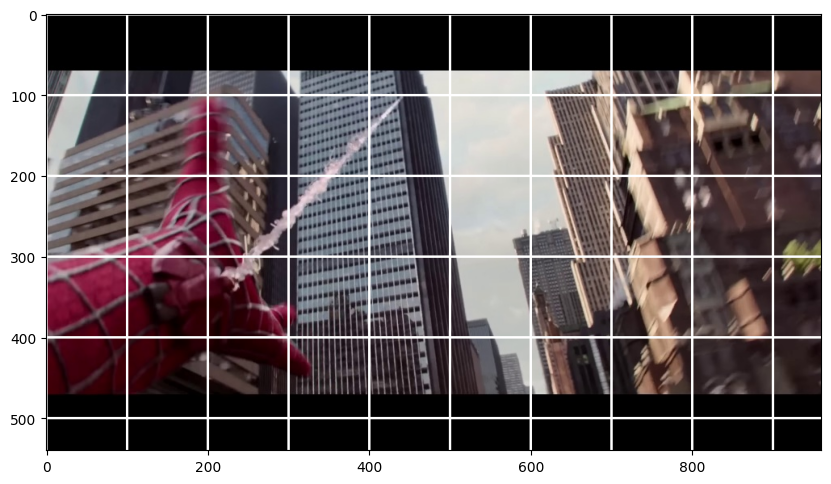

[(625, 150), (550, 350)]


In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"
ANNOTED_FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}-annotated.jpeg"

make_pixel_grid_with_lines(image_path = FRAME_PATH, output_path=ANNOTED_FRAME_PATH)

coordinates = analyze_image_coordinates(api_key=API_KEY, image_path=ANNOTED_FRAME_PATH, objects_to_find=unique_objects)
print(coordinates)

##LOWWER SETUP REMAINING

In [ ]:
# import requests
# import torch
# from PIL import Image
# import numpy as np
# from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# model_id_dino = "IDEA-Research/grounding-dino-tiny"
# device = "cuda" if torch.cuda.is_available() else "cpu"

# processor_dino = AutoProcessor.from_pretrained(model_id_dino)
# model_dino = AutoModelForZeroShotObjectDetection.from_pretrained(model_id_dino).to(device)

In [ ]:
# def calculate_bounding_box_areas_dino(bounding_boxes):
#     areas = []
#     for box in bounding_boxes:
#       if len(box) == 0:
#         areas.append(0)
#       else:
#         x1, y1, x2, y2 = box

#         # Calculate width and height of the bounding box
#         width = abs(x2 - x1)
#         height = abs(y2 - y1)

#         # Calculate area
#         area = width * height
#         areas.append(area // 1000)

#     return areas

In [ ]:
# def get_bounding_boxes_dino(image_path, text="a spyder man."):
#   image = Image.open(image_path).convert('RGB')

#   # Text prompt for detection
#   # text = "a spyder man."

#   # Process inputs
#   inputs = processor_dino(images=image, text=text, return_tensors="pt").to(device)

#   # Run inference
#   with torch.no_grad():
#       outputs = model_dino(**inputs)

#   # Post-process results
#   results = processor_dino.post_process_grounded_object_detection(
#       outputs,
#       inputs.input_ids,
#       box_threshold=0.4,
#       text_threshold=0.3,
#       target_sizes=[image.size[::-1]]
#   )[0]  # Get first (and only) image results

#   boxes = []

#   if len(results['boxes']) == 0:
#       return [], 0

#   # Print results in a more readable format
#   for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]


#     if len(results) <= 1:
#       return box, calculate_bounding_box_areas_dino(box)[0]
#     else:
#       # Do the max thing
#       boxes.append(box)

#   areas = calculate_bounding_box_areas_dino(boxes)
#   index_of_max = max(range(len(areas)), key=lambda i: areas[i])
#   return boxes[index_of_max], areas[index_of_max]

In [ ]:
# def calculate_center_dino(box):
#   if len(box) == 0:
#     return (0, 0)
#   x1, y1, x2, y2 = box

#   # Calculate width and height of the bounding box
#   width = abs(x2 - x1)
#   height = abs(y2 - y1)

#   # Calculate area
#   area = width * height

#   # Calculate center
#   center_x = int((x1 + x2) / 2)
#   center_y = int((y1 + y2) / 2)
#   return (center_x, center_y)

In [ ]:
# def get_max_info_frame_dino(image_paths, texts):
#     if isinstance(texts, str):
#         texts = [texts]

#     cumulative_areas = []
#     all_boxes = []
#     all_centers = []

#     for img in image_paths:
#         total_area = 0
#         best_box = []
#         best_center = []
#         for text in texts:
#             box, area = get_bounding_boxes_dino(img, text)
#             if box is not None:
#                 total_area += area
#                 center = calculate_center_dino(box)

#                 best_box.append(box)
#                 best_center.append(center)
#             else:
#                 best_box.append([])
#                 best_center.append([])

#         cumulative_areas.append(total_area)
#         all_boxes.append(best_box if best_box else [])
#         all_centers.append(best_center if best_center else [])

#     index_of_max = max(range(len(cumulative_areas)), key=lambda i: cumulative_areas[i])
#     return image_paths[index_of_max], all_boxes[index_of_max], all_centers[index_of_max]

In [ ]:
# def get_frame_id(file_path):
#     """
#     Extracts the frame ID (number before the file extension) from a file path.

#     Parameters:
#         file_path (str): The file path as a string.

#     Returns:
#         str: The frame ID as a string.
#     """
#     # Extract the base name of the file (e.g., '00100.jpeg')
#     file_name = os.path.basename(file_path)

#     # Split the file name into the name and extension
#     frame_id = os.path.splitext(file_name)[0]

#     return frame_id

In [ ]:
# import os

# # Define the source folder
# source_folder = FRAMES_FOLDER_ADDRESS  # Update this to your folder path

# # Get a sorted list of all image files in the source folder
# image_files = sorted(
#     [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
# )

# # Determine the interval to pick 10 frames evenly
# total_frames = len(image_files)
# if total_frames < 10:
#     raise ValueError("Not enough frames to select 10 different frames.")

# interval = total_frames // 10

# # Generate the list of paths for the selected frames
# selected_frames = [
#     os.path.join(source_folder, image_files[i * interval])
#     for i in range(10)
# ]

# # Print or use the list of selected frames
# print("Selected frame paths:")
# for frame in selected_frames:
#     print(frame)


In [ ]:
# # TODO:Do Check the full stop thing in the prompt

# frame_path, boxes, centers = get_max_info_frame_dino(image_paths=selected_frames, texts=['Spider-Man.'])
# print(frame_path, boxes, centers)

In [ ]:
# FRAME_IDX = int(get_frame_id(frame_path))

In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# def paint_point_on_image(image_path, x, y, output_path=None, point_color=(255, 0, 0), point_radius=12):
#     import cv2
#     import matplotlib.pyplot as plt

#     # Load the image
#     image = cv2.imread(image_path)
#     if image is None:
#         print("Error: Could not load image.")
#         return

#     # Paint the point on the image
#     cv2.circle(image, (x, y), radius=point_radius, color=point_color, thickness=-1)

#     # Convert to RGB for displaying in matplotlib
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Display the image with matplotlib
#     plt.imshow(image_rgb)
#     plt.axis('on')
#     plt.title(f"Point painted at ({x}, {y})")
#     plt.show()

#     # Save the image if an output path is provided
#     # if output_path:
#     #     cv2.imwrite(output_path, image)

# paint_point_on_image(frame_path, centers[0][0], centers[0][1])

##UPPER SETUP REMAINING

**NOTE:** Let's choose the index of the reference frame that we will use to annotate the objects we are looking for.

**NOTE:** The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

In [ ]:
# TODO

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget.classes = unique_objects
widget.bboxes = [{'x': x_axis, 'y': y_axis, 'width': 0, 'height': 0, 'label': label_name} for (x_axis, y_axis), label_name in zip(coordinates, unique_objects)]

In [ ]:
# # # TODO

# widget = BBoxWidget(classes=OBJECTS)
# widget.image = encode_image(frame_path)
# widget.classes = OBJECTS
# widget.bboxes = [{'x': x_axis, 'y': y_axis, 'width': 0, 'height': 0, 'label': label_name} for (x_axis, y_axis), label_name in zip(centers, unique_objects)]

BBoxWidget(bboxes=[{'x': 625, 'y': 150, 'width': 0, 'height': 0, 'label': 'Spiderman'}, {'x': 550, 'y': 350, 'width': 0, 'height': 0, 'label': 'Empire State Building'}], classes=['Spiderman', 'Empire State Building'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], image='', image_url='')

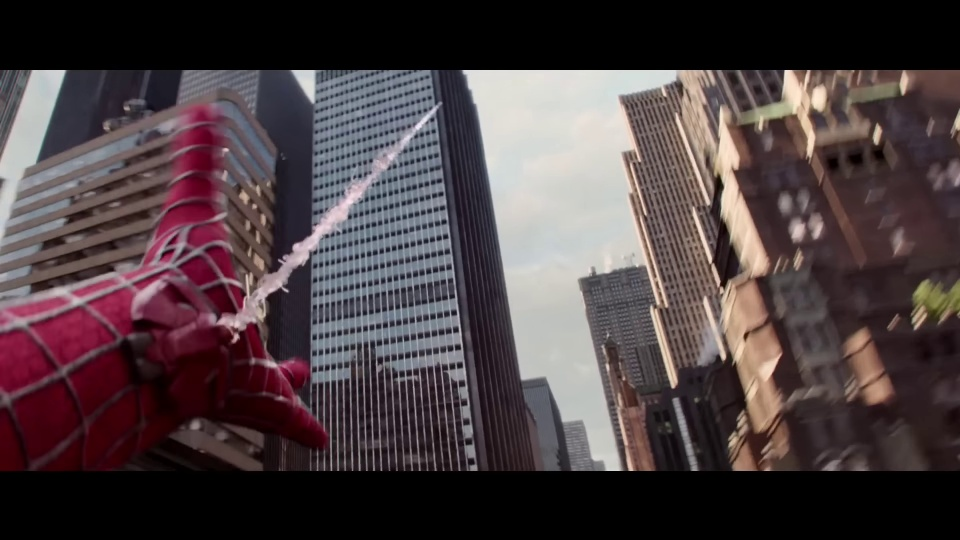
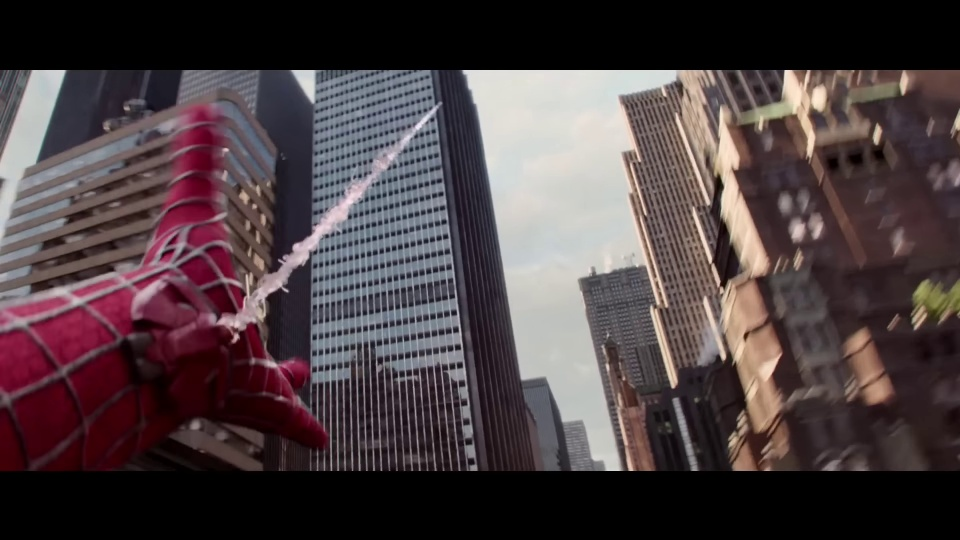

In [ ]:
print(widget)

In [ ]:
# default_box = [
#     {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'ball'},
#     {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'player-1'},
#     {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'player-2'}
# ]
# boxes = widget.bboxes if widget.bboxes else default_box
# boxes = default_box

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

### Video inference

**NOTE:** To apply our point prompts to all video frames, we use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which we can convert to masks using thresholding.

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []
detections_list = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )
        detections_list.append(sv.mask_to_xyxy(masks=masks))

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


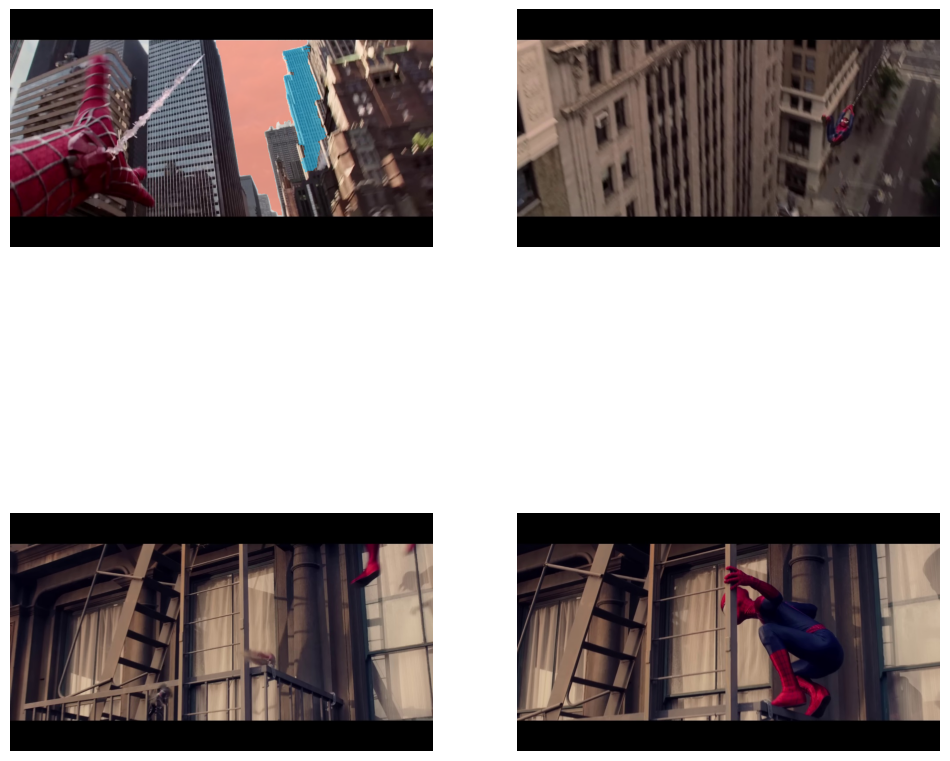

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)

In [ ]:
# File path for saving
file_path = "/content/detections.txt"

# Save the detections list to a text file
with open(file_path, "w") as file:
    for detection in detections_list:
        file.write(str(detection) + "\n")

print(f"Detections saved to {file_path}")

Detections saved to /content/detections.txt


In [ ]:
def calculate_916_crop(bounding_boxes, image_width, image_height):
    """
    Calculate a consistent 9:16 crop that maintains focus on the center of primary or large objects,
    ensuring the crop stays within the image boundaries.

    Args:
        bounding_boxes: Array or list of [x1, y1, x2, y2] coordinates, ordered by importance
        image_width: Original image width
        image_height: Original image height

    Returns:
        [x1, y1, x2, y2] coordinates for 9:16 crop
    """
    # Define 9:16 target ratio
    target_ratio = 9 / 16

    # Determine fixed crop dimensions based on video size
    if image_width / image_height > target_ratio:
        # Height is limiting factor
        crop_height = image_height
        crop_width = crop_height * target_ratio
    else:
        # Width is limiting factor
        crop_width = image_width
        crop_height = crop_width / target_ratio

    # Add padding if desired (e.g., 10%)
    padding_factor = 1.1
    crop_width *= padding_factor
    crop_height *= padding_factor

    # Ensure crop doesn't exceed image dimensions
    crop_width = min(crop_width, image_width)
    crop_height = min(crop_height, image_height)

    # Handle bounding_boxes
    if bounding_boxes is None or len(bounding_boxes) == 0:
        center_x, center_y = image_width / 2, image_height / 2
    else:
        # Convert to list if it's a NumPy array
        if isinstance(bounding_boxes, np.ndarray):
            bounding_boxes = bounding_boxes.tolist()

        # Find the largest object (by area) in the bounding boxes
        largest_box = max(
            bounding_boxes,
            key=lambda box: (box[2] - box[0]) * (box[3] - box[1])
        )
        # Center the crop on the largest object's center
        center_x = (largest_box[0] + largest_box[2]) / 2
        center_y = (largest_box[1] + largest_box[3]) / 2

    # Calculate initial crop coordinates
    x1 = max(0, center_x - crop_width / 2)
    y1 = max(0, center_y - crop_height / 2)
    x2 = x1 + crop_width
    y2 = y1 + crop_height

    # Adjust crop if it exceeds boundaries
    if x2 > image_width:
        x2 = image_width
        x1 = x2 - crop_width
    if y2 > image_height:
        y2 = image_height
        y1 = y2 - crop_height
    if x1 < 0:
        x1 = 0
        x2 = crop_width
    if y1 < 0:
        y1 = 0
        y2 = crop_height

    # Ensure crop coordinates stay within the image boundaries
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image_width, x2)
    y2 = min(image_height, y2)

    return [int(x1), int(y1), int(x2), int(y2)]


In [ ]:
import cv2

def process_video_with_boxes(video_path, detections_list, output_path):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    color = (0, 255, 0)
    thickness = 2

    while cap.isOpened():  # Corrected this line
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count < len(detections_list):
            boxes = detections_list[frame_count]
            # print(boxes, type(boxes))
            crop_coords = calculate_916_crop(boxes, width, height)
            cv2.rectangle(frame,
                         (crop_coords[0], crop_coords[1]),
                         (crop_coords[2], crop_coords[3]),
                         color, thickness)

        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()

# Example usage
video_path = f"{FRAMES_FOLDER_ADDRESS}-result.mp4"
output_path = f"{FRAMES_FOLDER_ADDRESS}-segmented-rectangle-output.mp4"

# Make sure `detections_list` and `calculate_916_crop` are properly defined
process_video_with_boxes(video_path, detections_list, output_path)


In [ ]:
import cv2

def process_video_with_boxes(video_path, detections_list, output_path, output_width=1080, output_height=1920):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (output_width, output_height))

    frame_count = 0
    color = (0, 255, 0)
    thickness = 2

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count < len(detections_list):
            boxes = detections_list[frame_count]
            # Get the coordinates for cropping the frame
            crop_coords = calculate_916_crop(boxes, width, height)

            # Crop the frame using the coordinates (adjusted to 9:16 aspect ratio)
            cropped_frame = frame[crop_coords[1]:crop_coords[3], crop_coords[0]:crop_coords[2]]

            # Resize the cropped frame to the desired 9:16 aspect ratio (output_width x output_height)
            cropped_frame_resized = cv2.resize(cropped_frame, (output_width, output_height))

            # Write the resized cropped frame to the output video
            out.write(cropped_frame_resized)

        frame_count += 1

    cap.release()
    out.release()

# Example usage
video_path = f"{FRAMES_FOLDER_ADDRESS}-result.mp4" # TODO: Change this with the original video, or the video without segmentation
output_path = f"{FRAMES_FOLDER_ADDRESS}-final-output.mp4"

# Ensure `detections_list` and `calculate_916_crop` are properly defined
process_video_with_boxes(video_path, detections_list, output_path, output_width=1080, output_height=1920)


In [ ]:
# Do add the voice support

# Change the souce path

# Chnage the indexes

# proper frame for the initialization

# take the name of the image which have all the objects from the claude only

# What happens if there is nothing to segment in the frame, then consider the last choice of the segment and continue with it

In [ ]:
# While taking the subject, instead take a little description of the subject